In [13]:
import glob
import json
import typing

import langdetect
import pandas as pd
import seaborn as sns
import matplotlib as mpl

import config

In [14]:
CFG = config.Config()
LANG: str = 'de'

In [18]:
raw_samples: typing.List[dict] = [
    json.load(open(file, 'r'))
    for file in glob.glob(f'{CFG.data_raw_dir}/*.json')
]
open(f'{CFG.data_dir}/{CFG.dataset_name}.json', 'w').write(json.dumps(raw_samples, indent=4, ensure_ascii=False))
len(raw_samples)

AttributeError: 'Config' object has no attribute 'data_raw_dir'

In [12]:
dataset: pd.DataFrame = (
    pd.json_normalize(raw_samples)
    .astype({'model': 'category'})
    .pipe(lambda _df: _df.assign(model=_df['model'].str.replace(':.*','', regex=True)))
)
dataset.to_parquet(f'{CFG.data_dir}/{CFG.dataset_name}.parquet')
dataset

AttributeError: 'Config' object has no attribute 'data_dir'

In [9]:
dataset['model'].value_counts()

model
llama2:70b-chat-q6_K               3445
falcon:40b-instruct-q5_1           3402
qwen:72b-chat-v1.5-q6_K            2977
mixtral:8x7b-instruct-v0.1-q6_K    2549
Name: count, dtype: int64

In [10]:
dataset['lang'] = dataset.apply(lambda row: langdetect.detect(row.response) if len(row.response) > 1 else None, axis=1)
dataset[['model', 'lang']].value_counts()

model                            lang 
falcon:40b-instruct-q5_1         en       3278
llama2:70b-chat-q6_K             en       1946
mixtral:8x7b-instruct-v0.1-q6_K  de       1600
qwen:72b-chat-v1.5-q6_K          de       1486
llama2:70b-chat-q6_K             de       1486
qwen:72b-chat-v1.5-q6_K          zh-cn     995
mixtral:8x7b-instruct-v0.1-q6_K  en        940
qwen:72b-chat-v1.5-q6_K          en        386
falcon:40b-instruct-q5_1         de        120
qwen:72b-chat-v1.5-q6_K          es         41
                                 no         17
                                 it         12
                                 ko         12
llama2:70b-chat-q6_K             nl         11
mixtral:8x7b-instruct-v0.1-q6_K  nl          9
qwen:72b-chat-v1.5-q6_K          ja          8
                                 tr          5
                                 pt          4
                                 fr          3
                                 ca          2
                     

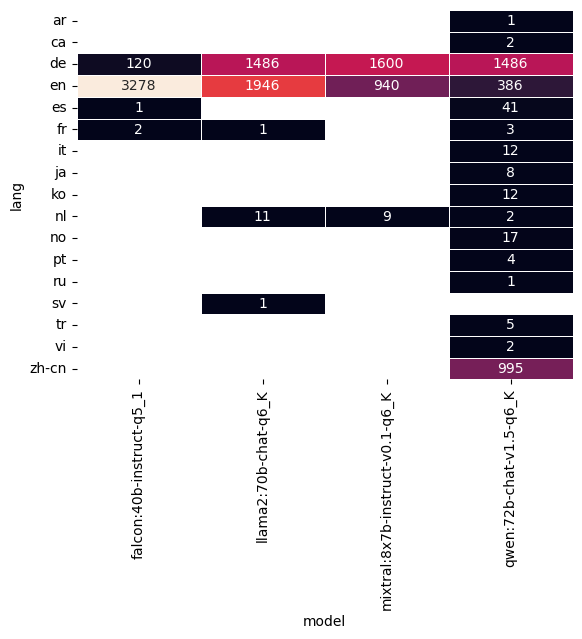

In [11]:
sns.heatmap(
    (
        dataset[['model', 'lang']]
        .value_counts()
        .to_frame()
        .reset_index()
        .pivot(index="model", columns="lang", values="count")
        .T
    ),
    annot=True,
    fmt='g',
    linewidth=.5,
    cbar=False
)
mpl.pyplot.savefig(f'{CFG.report_dir}/plot.heat.model.lang.pdf', format='pdf')

In [8]:
german_subset: pd.DataFrame = dataset[dataset.lang == LANG]
german_subset.to_csv(f'{CFG.data_dir}/{CFG.dataset_name}.{LANG}.csv')
german_subset.to_parquet(f'{CFG.data_dir}/{CFG.dataset_name}.{LANG}.parquet')
german_subset['model'].value_counts()

model
qwen:72b        2048
mixtral:8x7b    1937
llama2:70b      1918
falcon:40b        81
Name: count, dtype: int64

In [9]:
german_subset_stratified: pd.DataFrame = german_subset.groupby('model', observed=False).sample(n=80)
german_subset_stratified.to_csv(f'{CFG.data_dir}/{CFG.dataset_name}.{LANG}.strat.csv')
german_subset_stratified.to_parquet(f'{CFG.data_dir}/{CFG.dataset_name}.{LANG}.strat.parquet')